In [1]:
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import os
import PIL
import PIL.Image
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
import dask.bag as bag
from dask.diagnostics import ProgressBar
import matplotlib.cm as cm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Exploratory data analysis

This block of code initializes file paths for the folders and images that are going to be used for the exploratory data analysis.

In [2]:
train_dir = Path('dataset2/train')
train_filepaths_jpg = list(train_dir.rglob(r'**/*.jpg'))
train_filepaths_jpeg = list(train_dir.rglob(r'**/*.jpeg'))
train_filepaths_png = list(train_dir.rglob(r'**/*.png'))
train_filepaths = train_filepaths_jpg + train_filepaths_jpeg + train_filepaths_png


def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
train_df = train_df.sort_values("Label")
labels = train_df["Label"].unique()
labels.sort()
# train_df
# train_df.loc[train_df["Label"] == label]

i=0
imagePath = {}

for label in labels:
    imagePath[i] = [fn for fn in os.listdir(f'{train_dir}\\{label}') if fn.endswith('.jpg')]
    temp = [fn for fn in os.listdir(f'{train_dir}\\{label}') if fn.endswith('.png')]
    for j in temp:
        imagePath[i].append(j)
    temp = [fn for fn in os.listdir(f'{train_dir}\\{label}') if fn.endswith('.jpeg')]
    for j in temp:
        imagePath[i].append(j)
    i+=1

# Distribution of Sizes
The distribution of sizes is shown by obtaining the dimensions of the image namely its height, weight, and depth if it has depth. The height and weight are then compiled into a scatterplot for easy visualization with each fruit and vegetable having its own graph. Knowing the distribution of sizes can help us understand which size is appropriate to be used for pre-processing purposes to normalize the sizes of each image and better tune the model.

In [3]:
# Distribution of Sizes
classDirectories = {}
for label in labels:
    classDirectories[label] = 'dataset2/train/' + label + '/'

def get_dims(file):
    im = Image.open(file)
    arr = np.array(im)
    if (len(arr.shape) == 3):
        h,w,d = arr.shape
    else:
        h,w = arr.shape
    return h,w

[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  3.7s
[########################################] | 100

C:\Users\Allen\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  3.8s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  3.5s


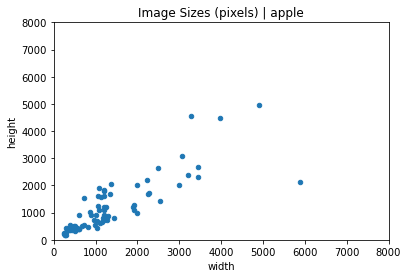

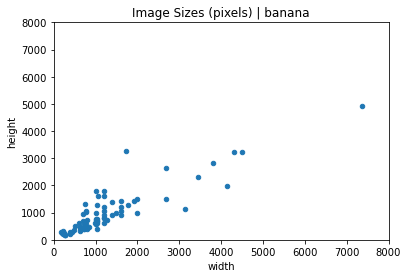

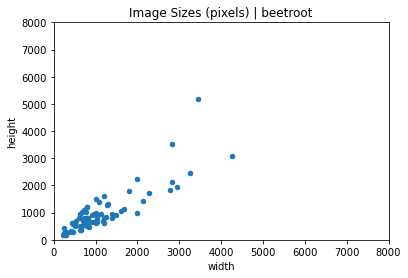

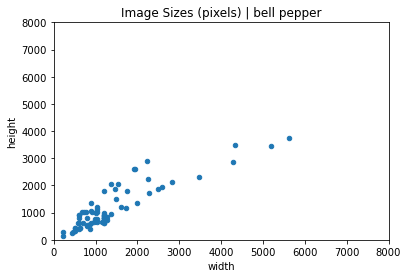

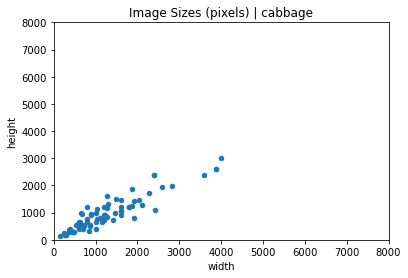

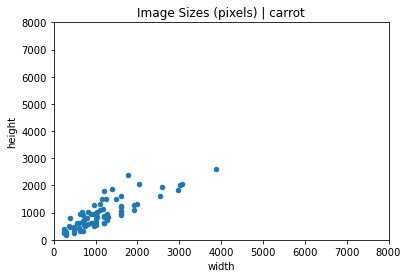

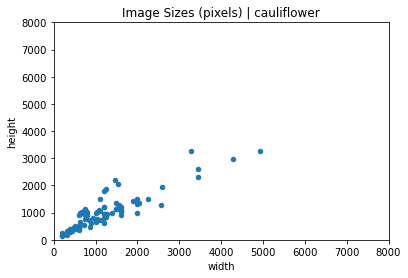

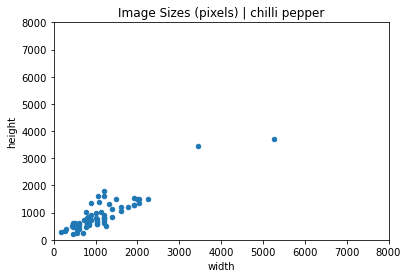

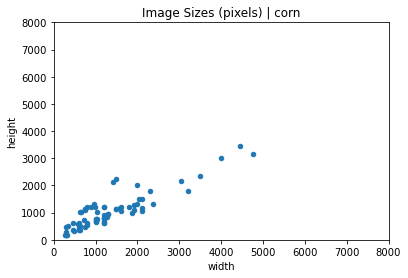

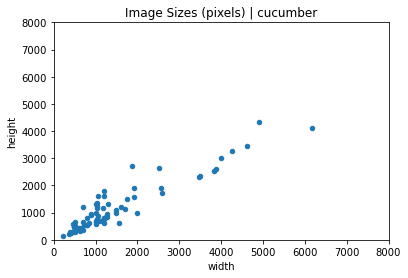

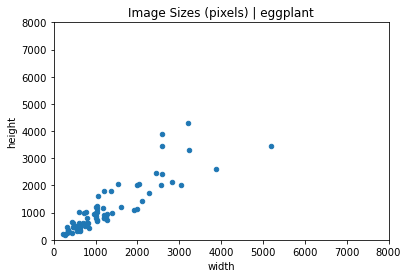

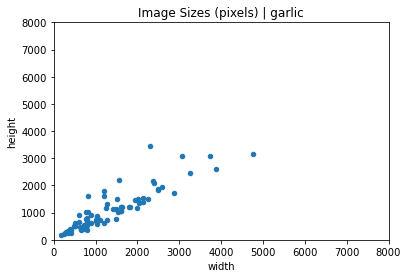

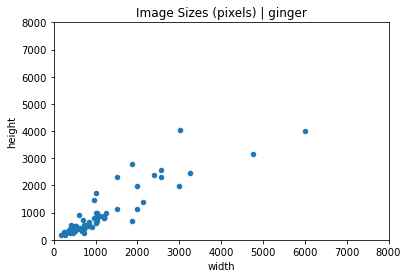

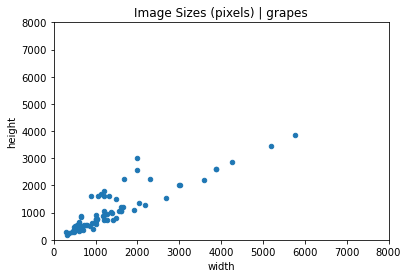

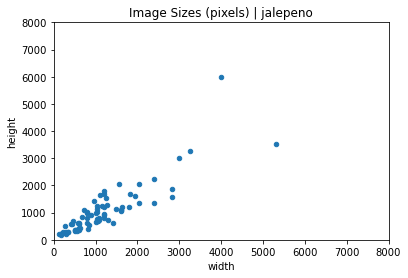

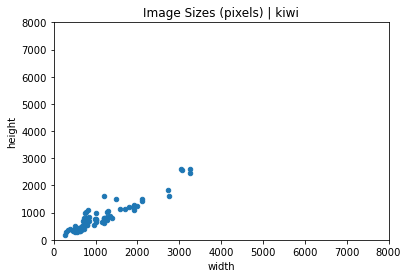

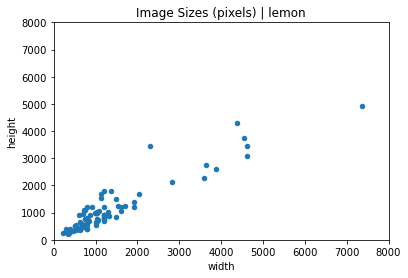

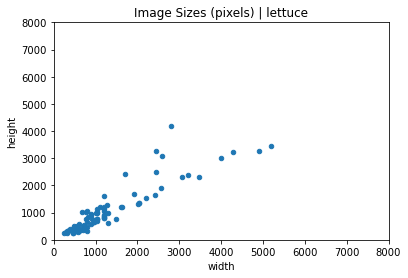

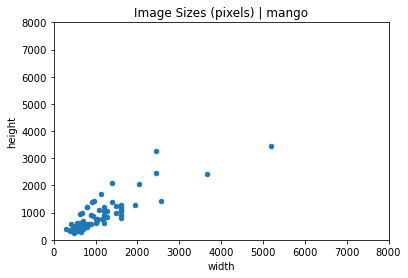

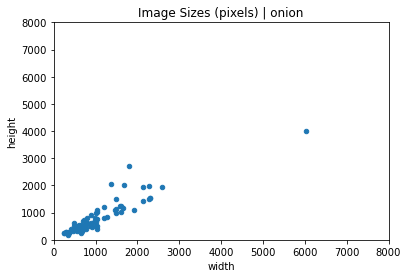

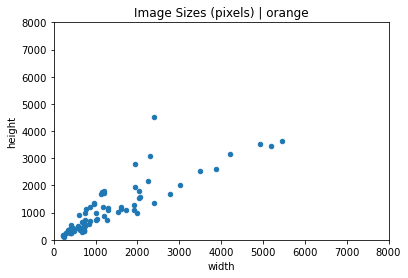

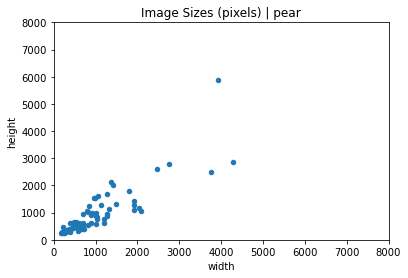

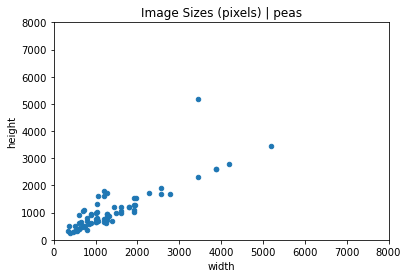

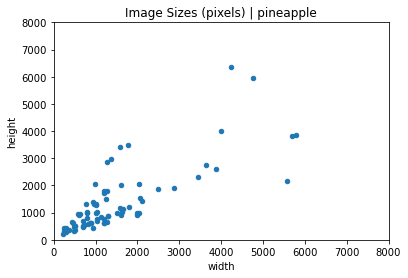

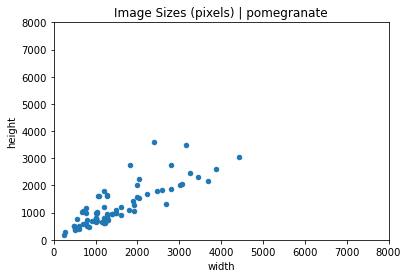

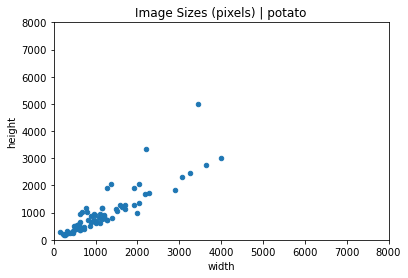

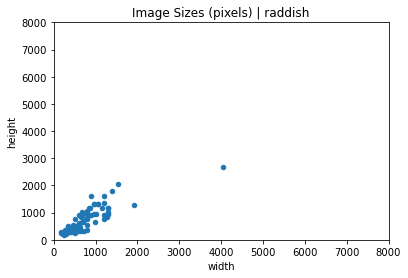

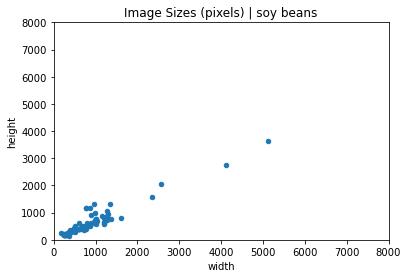

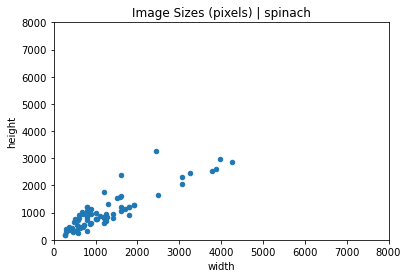

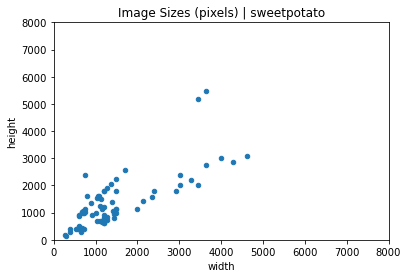

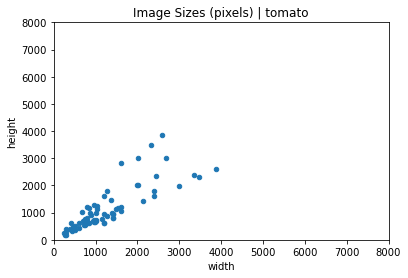

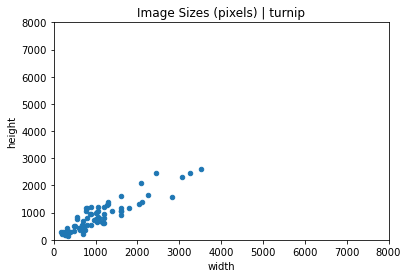

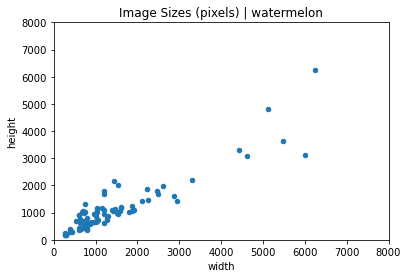

In [4]:
for n,d in classDirectories.items():
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = bag.from_sequence(filelist).map(get_dims)
    with ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        sizes.plot.scatter(x='width', y='height');
        plt.xlim(0, 8000)
        plt.ylim(0, 8000)
        plt.title('Image Sizes (pixels) | {}'.format(n))

It can be seen from the results above that most images gather around the 0-2000 height and width so it is important to run it again and limit the view to those of that size.

[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  3.7s
[########################################] | 100

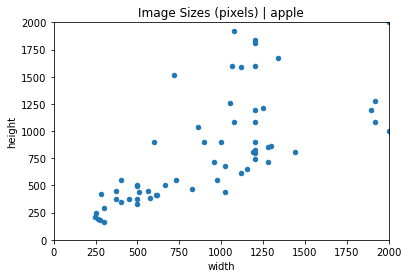

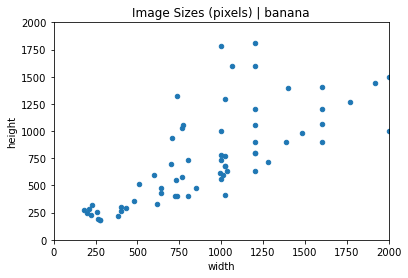

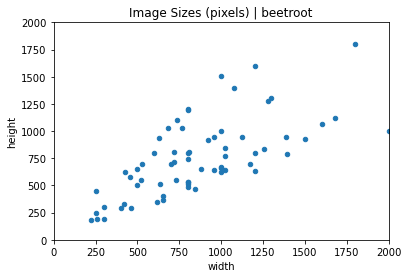

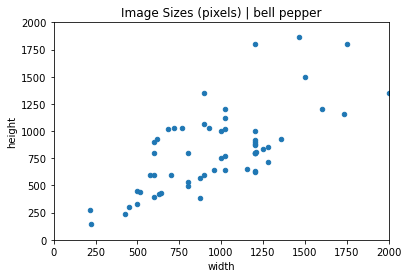

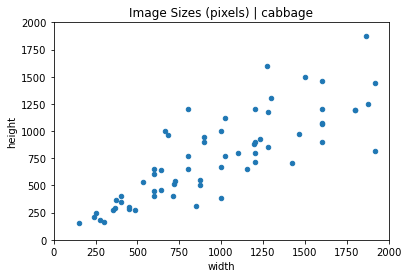

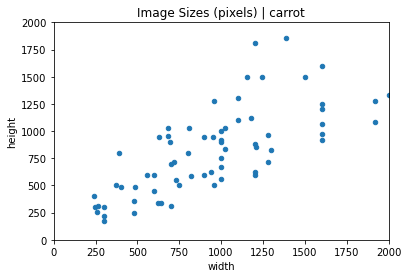

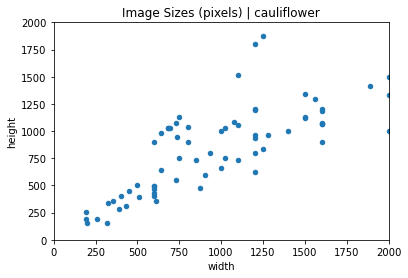

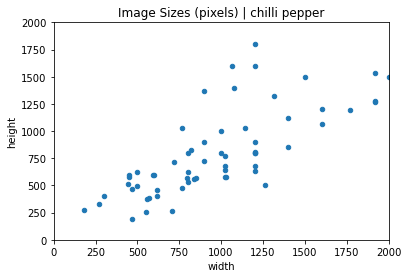

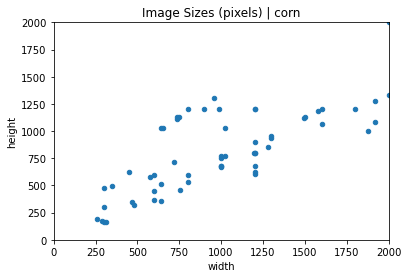

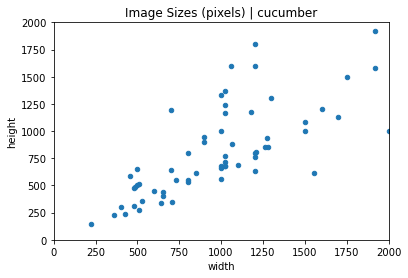

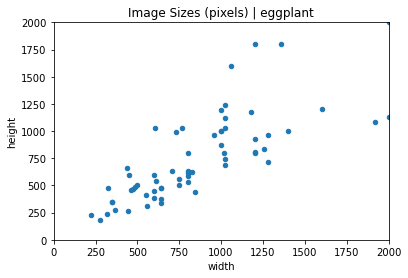

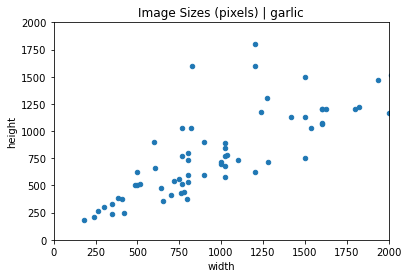

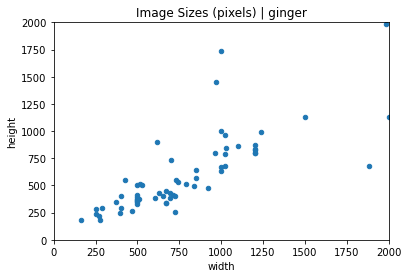

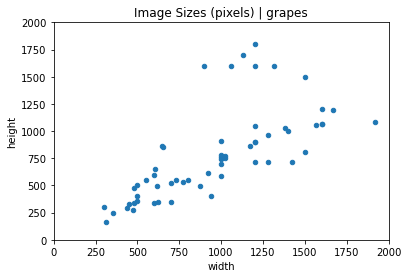

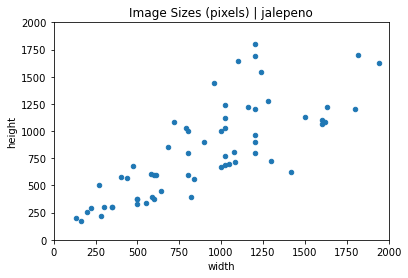

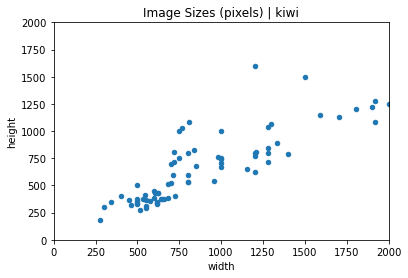

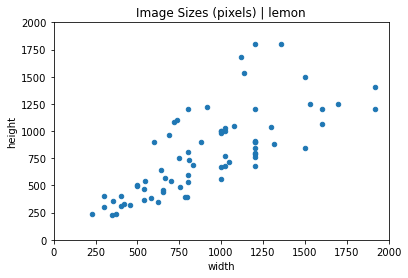

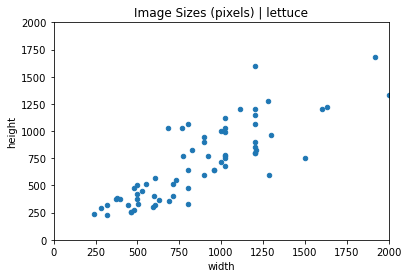

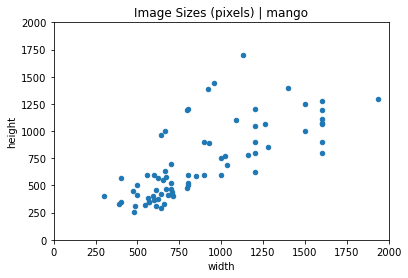

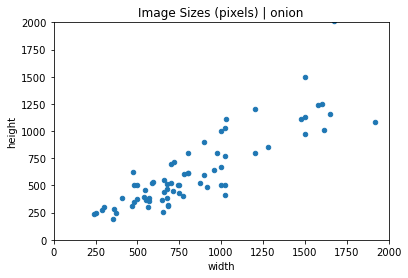

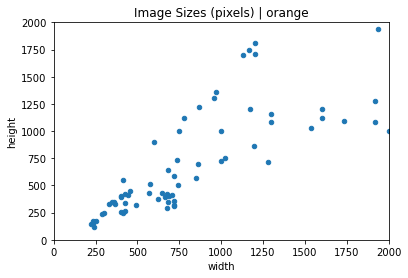

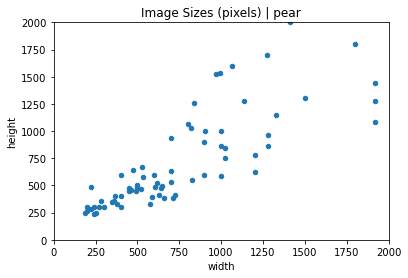

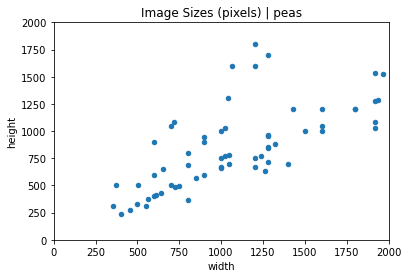

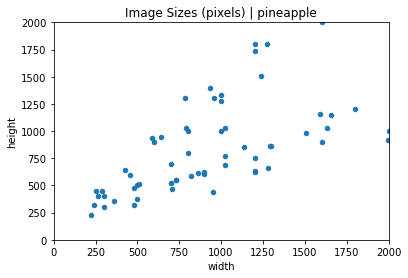

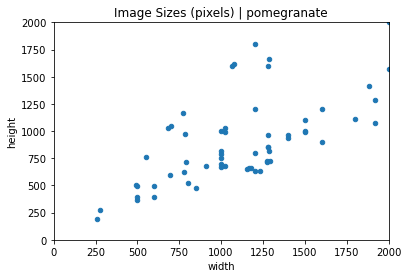

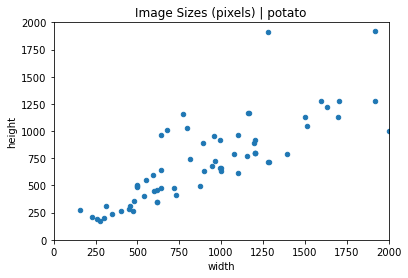

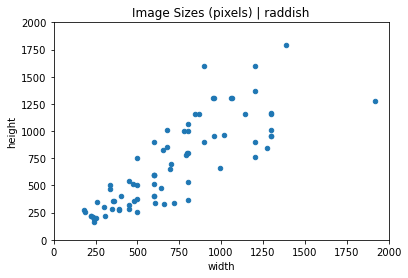

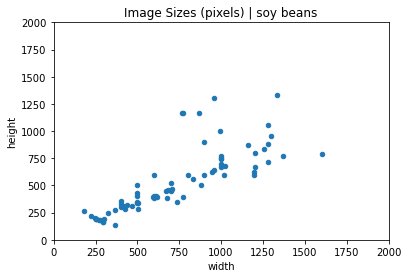

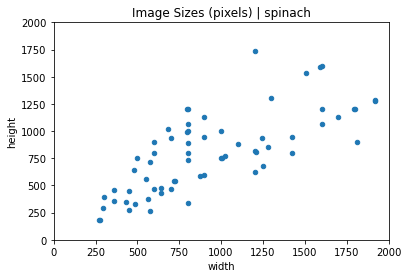

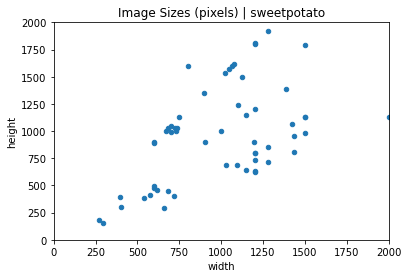

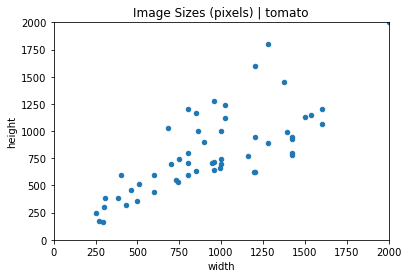

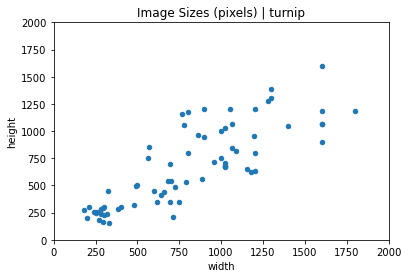

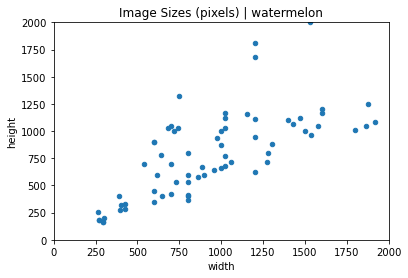

In [5]:
for n,d in classDirectories.items():
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = bag.from_sequence(filelist).map(get_dims)
    with ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        sizes.plot.scatter(x='width', y='height');
        plt.xlim(0, 2000)
        plt.ylim(0, 2000)
        plt.title('Image Sizes (pixels) | {}'.format(n))

It can be observed that most images land in the size 250x250 to 750x750

# Distribution of Labels
By checking the directories of each label the amount of images per fruit and vegetable can be shown in a bar graph with number of images in the y-axis and label in the x-axis. Knowing the proper distrubtion of labels can help determine which image has a different count from others. It is important for each label to have the same amount of images as it may affect the training of the model later on.

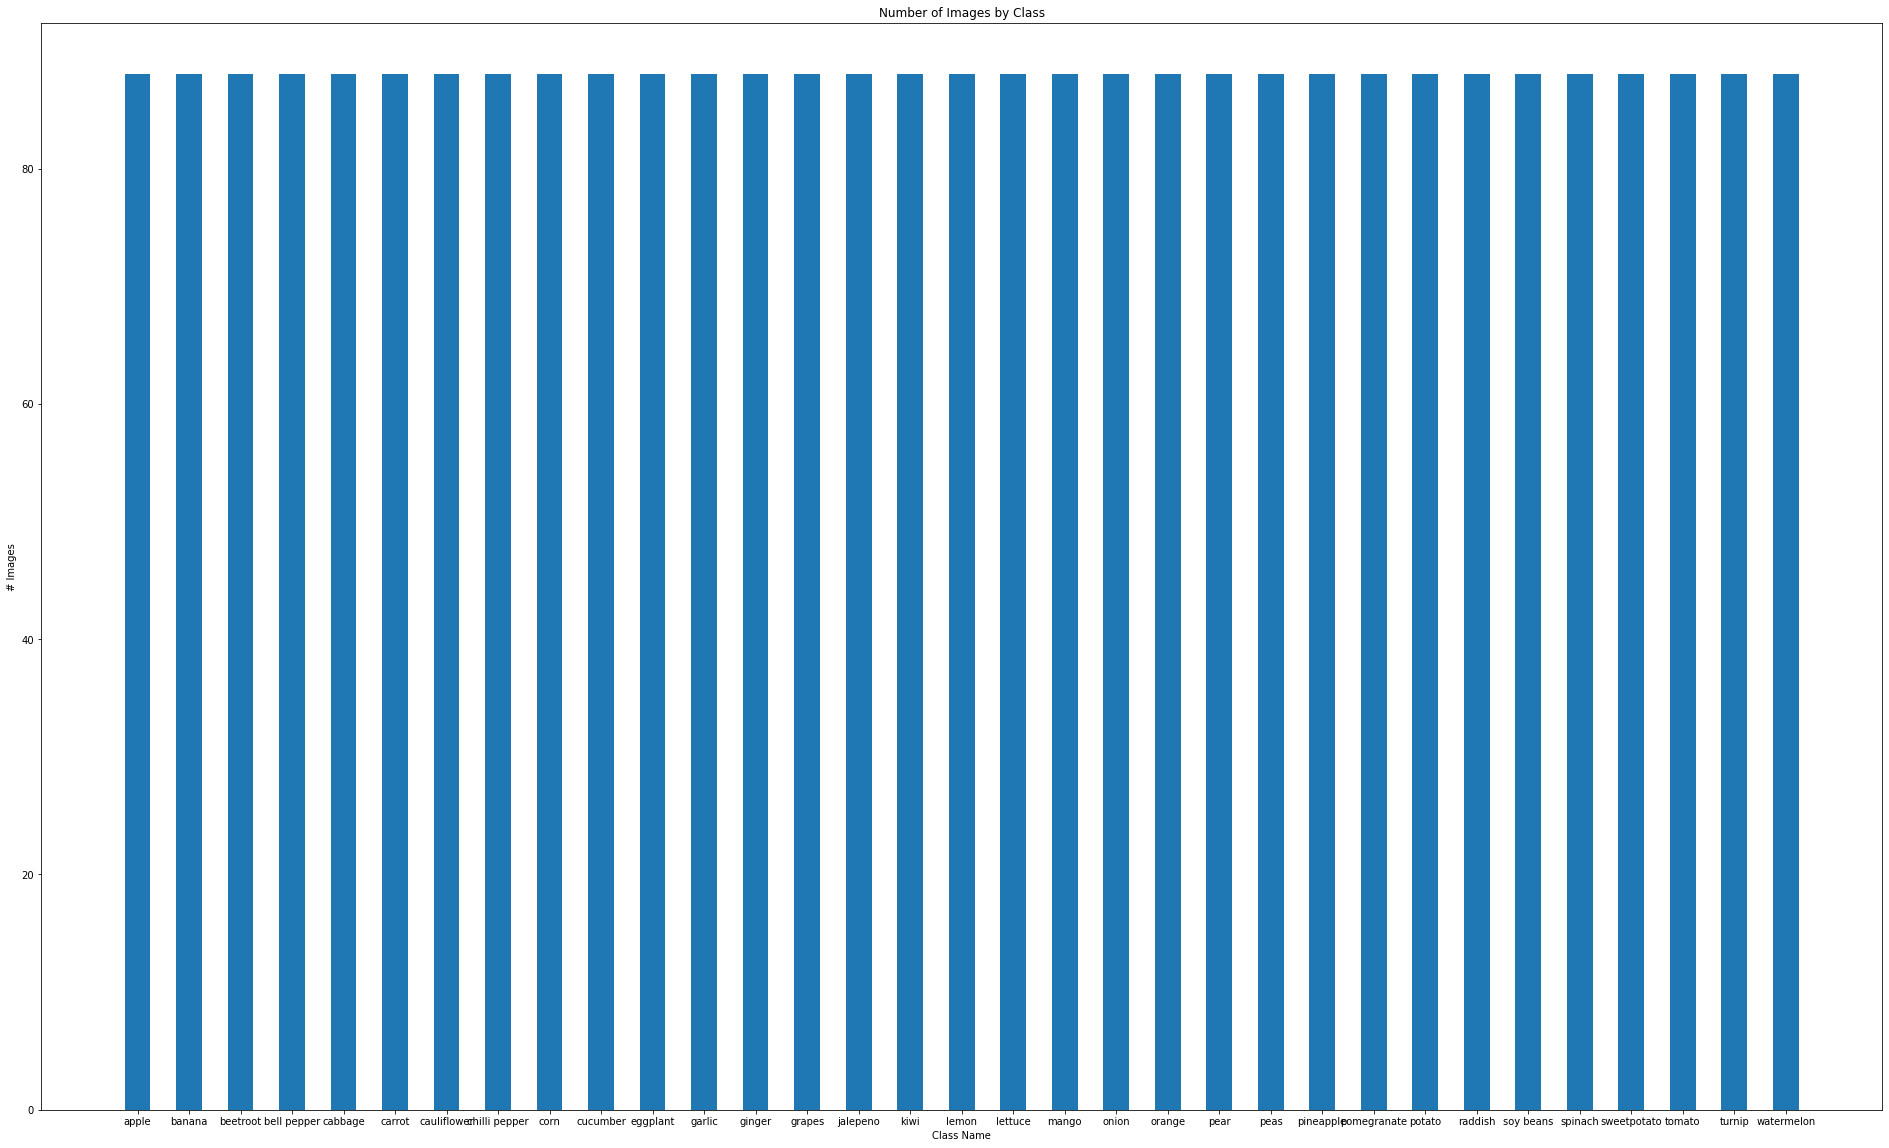

In [6]:
# Distribution of Labels
number_classes = {}
for label in labels:
    number_classes[label] = len(os.listdir(f'{train_dir}\\{label}'))
f, ax = plt.subplots(figsize=(33,20)) # set the size that you'd like (width, height)
plt.bar(number_classes.keys(), number_classes.values(), width = .5)
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

# Model

In [7]:
# Create a list with the filepaths for training and testing
train_dir = Path('dataset2/train')
train_filepaths = list(train_dir.glob(r'*/*'))

test_dir = Path('dataset2/test')
test_filepaths = list(test_dir.glob(r'*/*'))

val_dir = Path('dataset2/validation')
val_filepaths = list(test_dir.glob(r'*/*'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [8]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2904

Number of different labels: 33

Labels: ['peas' 'mango' 'pomegranate' 'apple' 'garlic' 'jalepeno' 'potato'
 'cabbage' 'sweetpotato' 'corn' 'cauliflower' 'bell pepper'
 'chilli pepper' 'tomato' 'eggplant' 'soy beans' 'kiwi' 'cucumber'
 'banana' 'watermelon' 'ginger' 'onion' 'pineapple' 'orange' 'spinach'
 'carrot' 'beetroot' 'lettuce' 'grapes' 'raddish' 'lemon' 'pear' 'turnip']


In [9]:
train_df.head(5)

,Filepath,Label
0,dataset2\train\peas\Image_8.jpg,peas
1,dataset2\train\peas\Image_84.jpg,peas
2,dataset2\train\peas\Image_33.png,peas
3,dataset2\train\mango\Image_77.JPG,mango
4,dataset2\train\pomegranate\Image_113.png,pomegranate


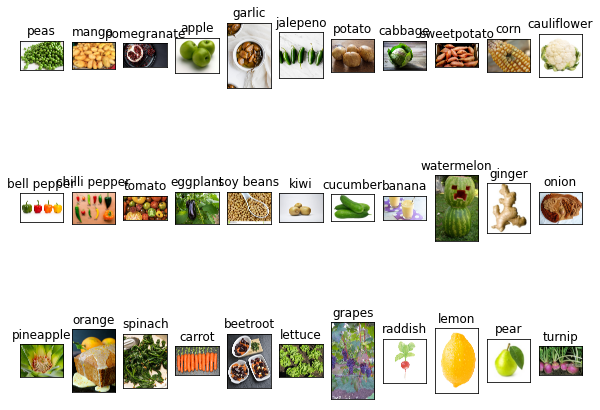

In [10]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=3, ncols=11, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2904 validated image filenames belonging to 33 classes.
Found 330 validated image filenames belonging to 33 classes.
Found 330 validated image filenames belonging to 33 classes.


In [12]:
pt_hyperparameters = ['avg', 'max']

adam_hyperparameters = [0.0001, 0.001, 0.01]

In [13]:
best_score = 0
for p in pt_hyperparameters :
    
    pretrained_model = tf.keras.applications.InceptionV3(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling=p
    )
    pretrained_model.trainable = False
    
    for l in adam_hyperparameters:
        print('=============================')
        print('POOLING: ' + p)
        print('LEARNING RATE: ' + str(l))
        inputs = pretrained_model.input

        x = tf.keras.layers.Dropout(0.2)(pretrained_model.output)
        outputs = tf.keras.layers.Dense(33, activation='softmax')(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=l),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        history = model.fit(
            train_images,
            validation_data=val_images,
            batch_size = 32,
            epochs=20,
        )
        
        val_acc = history.history['val_accuracy'][-1]
        
        if val_acc > best_score:
            best_score = val_acc
            best_params = {'p' : p, 'l' : l}

print("Best accuracy: ", best_score)
print("Best grid: ", best_params)

POOLING: avg
LEARNING RATE: 0.0001
Epoch 1/20
 1/91 [..............................] - ETA: 9:34 - loss: 4.4695 - accuracy: 0.0000e+00

C:\Users\Allen\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


91/91 [==============================] - 207s 2s/step - loss: 3.4192 - accuracy: 0.1016 - val_loss: 2.7427 - val_accuracy: 0.2879
Epoch 2/20
91/91 [==============================] - 197s 2s/step - loss: 2.4638 - accuracy: 0.3537 - val_loss: 2.0779 - val_accuracy: 0.4697
Epoch 3/20
91/91 [==============================] - 196s 2s/step - loss: 1.8996 - accuracy: 0.5186 - val_loss: 1.7080 - val_accuracy: 0.5788
Epoch 4/20
91/91 [==============================] - 204s 2s/step - loss: 1.5666 - accuracy: 0.5999 - val_loss: 1.4659 - val_accuracy: 0.6455
Epoch 5/20
91/91 [==============================] - 198s 2s/step - loss: 1.3343 - accuracy: 0.6653 - val_loss: 1.3199 - val_accuracy: 0.6636
Epoch 6/20
91/91 [==============================] - 198s 2s/step - loss: 1.1908 - accuracy: 0.7011 - val_loss: 1.2044 - val_accuracy: 0.7000
Epoch 7/20
91/91 [==============================] - 200s 2s/step - loss: 1.0668 - accuracy: 0.7331 - val_loss: 1.1277 - val_accuracy: 0.7121
Epoch 8/20
91/91 [======

91/91 [==============================] - 198s 2s/step - loss: 0.4051 - accuracy: 0.9415 - val_loss: 3.6973 - val_accuracy: 0.7242
Epoch 19/20
91/91 [==============================] - 198s 2s/step - loss: 0.2719 - accuracy: 0.9628 - val_loss: 3.2102 - val_accuracy: 0.7727
Epoch 20/20
91/91 [==============================] - 198s 2s/step - loss: 0.2841 - accuracy: 0.9511 - val_loss: 3.5767 - val_accuracy: 0.7545
POOLING: max
LEARNING RATE: 0.0001
Epoch 1/20
91/91 [==============================] - 205s 2s/step - loss: 5.3907 - accuracy: 0.0623 - val_loss: 3.4905 - val_accuracy: 0.1697
Epoch 2/20
91/91 [==============================] - 201s 2s/step - loss: 3.6741 - accuracy: 0.2052 - val_loss: 2.5298 - val_accuracy: 0.3545
Epoch 3/20
91/91 [==============================] - 200s 2s/step - loss: 2.7883 - accuracy: 0.3388 - val_loss: 1.9916 - val_accuracy: 0.4909
Epoch 4/20
91/91 [==============================] - 206s 2s/step - loss: 2.2879 - accuracy: 0.4242 - val_loss: 1.7008 - val_accu

91/91 [==============================] - 200s 2s/step - loss: 1.4589 - accuracy: 0.9118 - val_loss: 7.7943 - val_accuracy: 0.7515
Epoch 15/20
91/91 [==============================] - 199s 2s/step - loss: 1.1541 - accuracy: 0.9242 - val_loss: 8.1462 - val_accuracy: 0.6939
Epoch 16/20
91/91 [==============================] - 199s 2s/step - loss: 1.3952 - accuracy: 0.9101 - val_loss: 10.1035 - val_accuracy: 0.6879
Epoch 17/20
91/91 [==============================] - 199s 2s/step - loss: 1.2730 - accuracy: 0.9194 - val_loss: 8.4619 - val_accuracy: 0.7182
Epoch 18/20
91/91 [==============================] - 199s 2s/step - loss: 1.1974 - accuracy: 0.9242 - val_loss: 9.3295 - val_accuracy: 0.7606
Epoch 19/20
91/91 [==============================] - 199s 2s/step - loss: 1.1598 - accuracy: 0.9246 - val_loss: 11.3674 - val_accuracy: 0.6970
Epoch 20/20
91/91 [==============================] - 199s 2s/step - loss: 1.6453 - accuracy: 0.9136 - val_loss: 10.6120 - val_accuracy: 0.6970
Best accuracy: 

In [14]:
# Load the pretained model
pretrained_model = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [15]:
inputs = pretrained_model.input

x = tf.keras.layers.Dropout(0.2)(pretrained_model.output)
outputs = tf.keras.layers.Dense(33, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=2,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=2,
#             restore_best_weights=True
#         )
#     ]
)

Epoch 1/2
91/91 [==============================] - 204s 2s/step - loss: 1.7685 - accuracy: 0.5203 - val_loss: 1.0531 - val_accuracy: 0.7242
Epoch 2/2
91/91 [==============================] - 200s 2s/step - loss: 0.7508 - accuracy: 0.7841 - val_loss: 0.8284 - val_accuracy: 0.7667


In [16]:
val_acc = history.history['val_accuracy'][-1]
print(val_acc)

0.7666666507720947


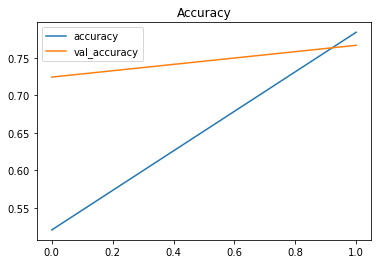

In [17]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

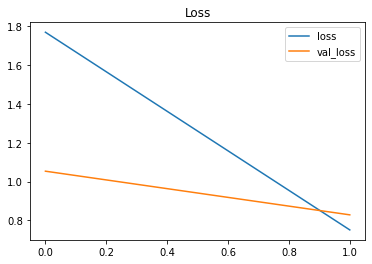

In [18]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [19]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

 2/11 [====>.........................] - ETA: 14s

C:\Users\Allen\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 [==============================] - 19s 1s/step


In [20]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 76.67%


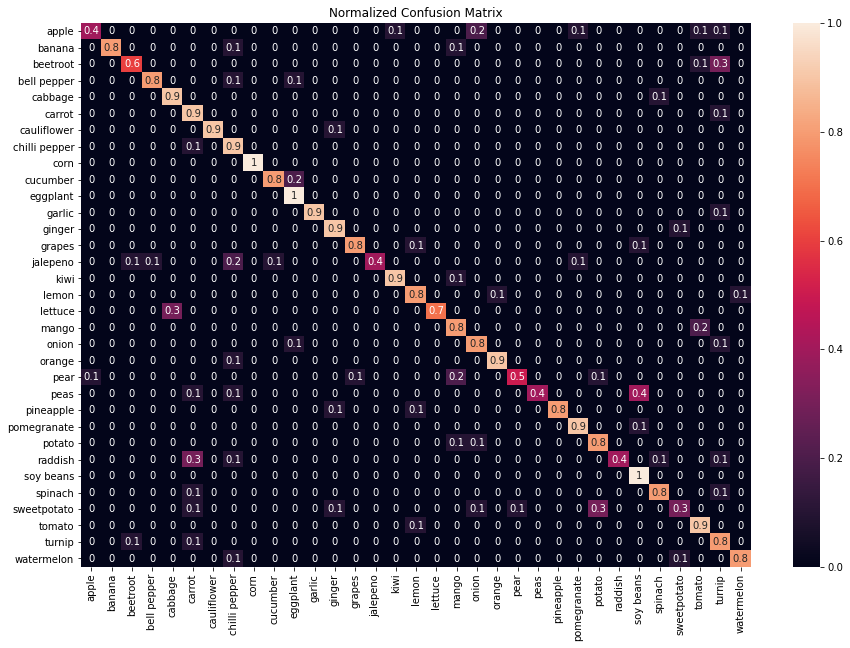

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

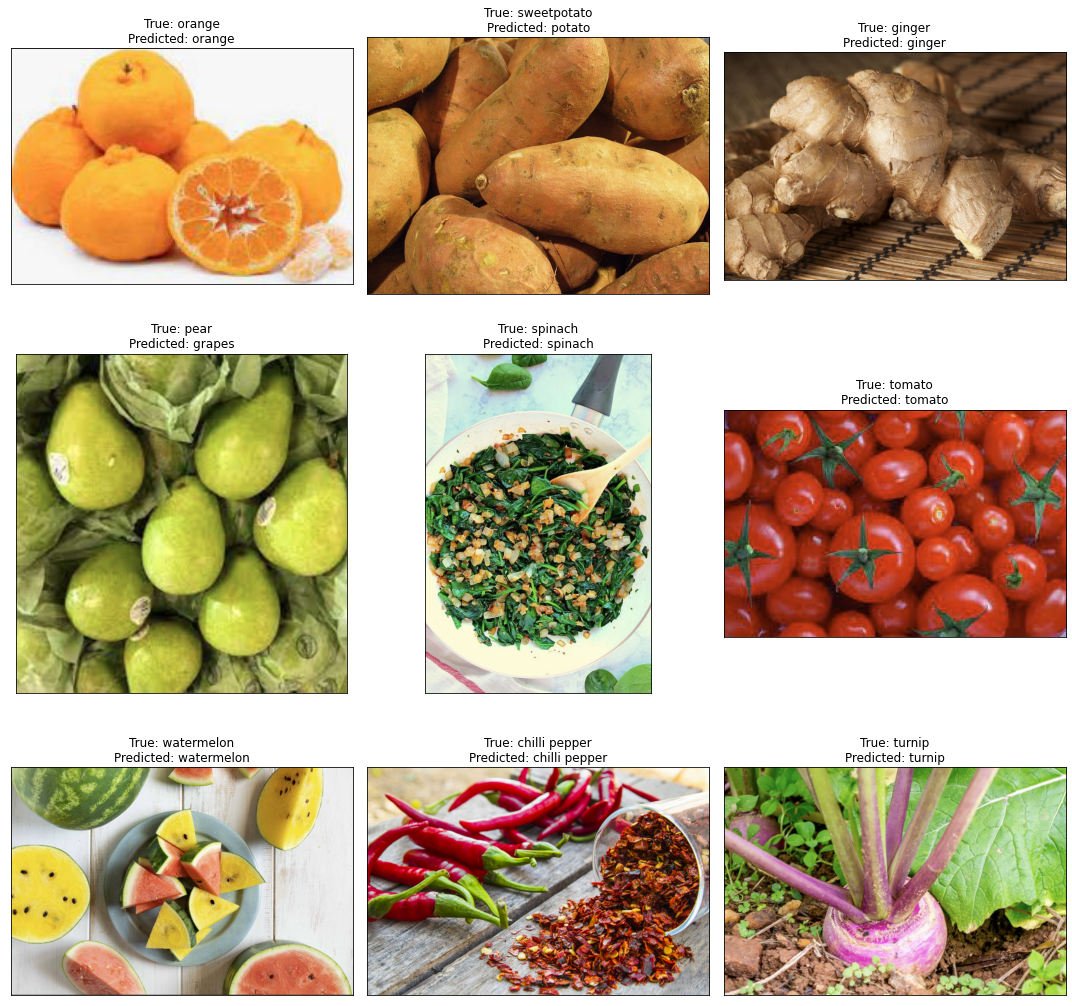

In [22]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()